In [46]:
import os
import sys
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu
from shutil import copyfile
plt.rcParams['font.size']=12

In [47]:
workspace = "workspace"
model_name = "mf6model"
exe_name="mf6.exe"

nrow = 280
ncol = 240

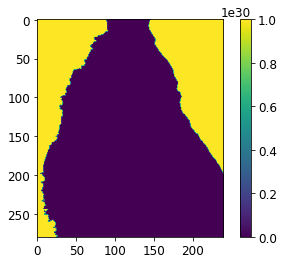

In [48]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

In [49]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package obs...
    loading package oc...
  loading ims package mf6model...
   could not remove start_datetime


In [50]:
#sr=pyemu.utils.helpers.SpatialReference.set_spatialreference(xul=None, yul=None, xll=None, yll=None, rotation=0.0)

In [51]:
xul, yul = 1098000, 1285000 # Model Origin

dxdy = 50 #grid spacing
delc = np.ones(nrow, dtype=float) * dxdy
delr = np.ones(ncol, dtype=float) * dxdy
rot = 0

sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc, xul=xul, yul=yul, rotation=rot, epsg='3116')
sr

xul:1098000; yul:1285000; rotation:0; proj4_str:+init=epsg:3116; units:meters; lenuni:2; length_multiplier:1.0

In [52]:
file = "heads.csv"
fileout = "workspace/heads.csv"
os.remove(fileout)
copyfile(file, fileout) # copy 

# empty pst from object
template_ws = "template"
pf = pyemu.utils.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2021-02-17 14:56:36.455277 starting: opening PstFrom.log for logging
2021-02-17 14:56:36.456304 starting PstFrom process
2021-02-17 14:56:36.458267 starting: setting up dirs
2021-02-17 14:56:36.458267 starting: removing existing new_d 'template'
2021-02-17 14:56:36.475223 finished: removing existing new_d 'template' took: 0:00:00.016956
2021-02-17 14:56:36.475223 starting: copying original_d 'workspace' to new_d 'template'
2021-02-17 14:56:36.524091 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.048868
2021-02-17 14:56:36.525569 finished: setting up dirs took: 0:00:00.067302


In [53]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

2021-02-17 14:56:36.794166 starting: adding observations from tabular output file
2021-02-17 14:56:36.794166 starting: reading list template\heads.csv
2021-02-17 14:56:36.796162 finished: reading list template\heads.csv took: 0:00:00.001996
2021-02-17 14:56:36.797161 starting: building insfile for tabular output file heads.csv
2021-02-17 14:56:36.804141 finished: building insfile for tabular output file heads.csv took: 0:00:00.006980
2021-02-17 14:56:36.804141 starting: adding observation from instruction file 'template\heads.csv.ins'
2021-02-17 14:56:36.810125 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.005984
2021-02-17 14:56:36.811125 finished: adding observations from tabular output file took: 0:00:00.016959
noptmax:30, npar_adj:0, nnz_obs:33


spatial variogram


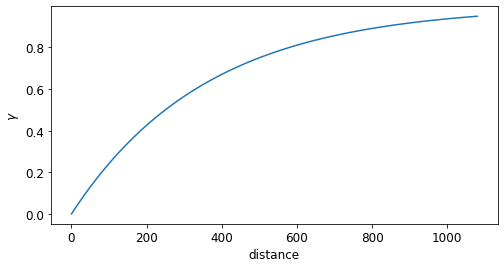

In [54]:
ppspace1=120
a = ppspace1*3.0
v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
grid_gs1 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs1.plot()
print("spatial variogram")

spatial variogram


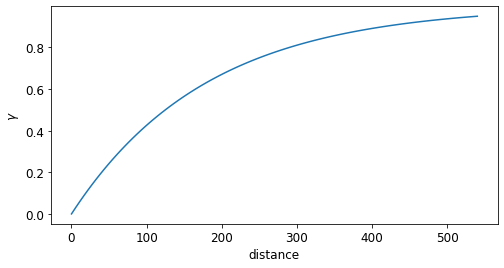

In [55]:
ppspace2=60
a = ppspace2*3.0
v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
grid_gs2 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs2.plot()
print("spatial variogram")

In [56]:
# set an homogeneous k array (as initial value)
# k = 1e-4*np.ones([nrow,ncol])
# filnm = "k.txt"
# np.savetxt(os.path.join(template_ws,filnm),k)

In [57]:
# Model domain in txt file because the code for some reason is not respecting my m.dis.idomain in the pilot point section
# maxsize to check these matrices very well!
np.set_printoptions(threshold=sys.maxsize)

ib0=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer0.txt"))
ib1=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer1.txt"))
ib2=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer2.txt"))
ib3=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer3.txt"))

ib=[ib0,ib1,ib2,ib3]

# To make sure only greater than zero values are being considered in the pilot point automated placement for all layers
nlay=4
for i in range(0,nlay):
    ib[i][ib[i]==-1]=0

In [58]:
#Horizontal conductivity for the 4 layers
#layer1
pf.add_parameters(filenames="hk0.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp0",pargp="hp", zone_array=ib[0], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=1.1921e-3,ult_lbound=1.1574e-8)
#layer2
pf.add_parameters(filenames="hk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp1",pargp="hp", zone_array=ib[1], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1921e-3,ult_lbound=1.1921e-5)
#layer3
pf.add_parameters(filenames="hk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="hp", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1574e-6,ult_lbound=1.1574e-8)
#layer4
pf.add_parameters(filenames="hk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="hp", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=4.167e-4,ult_lbound=4.167e-6)

#Vertical conductivity for the 4 layers
#layer1
pf.add_parameters(filenames="vk0.txt",par_type="pilotpoint",pp_space=ppspace1,
                  par_name_base="kp0",pargp="vp", zone_array=ib[0], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=2.1991e-4,ult_lbound=1.0417e-8)
#layer2
pf.add_parameters(filenames="vk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                  par_name_base="kp1",pargp="vp", zone_array=ib[1], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=2.1991e-4,ult_lbound=2.1991e-6)
#layer3
pf.add_parameters(filenames="vk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="vp", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.0417e-6,ult_lbound=1.0417e-8)
#layer4
pf.add_parameters(filenames="vk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="vp", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=1.736e-5,ult_lbound=1.736e-7)



2021-02-17 14:56:38.458837 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk0.txt']
2021-02-17 14:56:38.458837 starting: loading array template\hk0.txt
2021-02-17 14:56:38.522755 finished: loading array template\hk0.txt took: 0:00:00.063918
2021-02-17 14:56:38.522755 loaded array 'hk0.txt' of shape (280, 240)
2021-02-17 14:56:38.578599 starting: writing array-based template file 'kp0_inst0_pilotpoint.csv.tpl'
2021-02-17 14:56:38.578599 starting: setting up pilot point parameters
2021-02-17 14:56:38.599514 2 pilot point parameters created
2021-02-17 14:56:38.600527 pilot point 'pargp':kp0_inst:0
2021-02-17 14:56:38.600527 finished: setting up pilot point parameters took: 0:00:00.021928
2021-02-17 14:56:38.601539 starting: calculating factors for pargp=kp0_inst:0
2021-02-17 14:56:38.601539 saving krige variance file:template\kp0_inst0pp.var.dat
2021-02-17 14:56:38.601539 saving krige factors file:template\kp0_inst0pp.fac
starting interp point loop for 67200 po

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 68.821076 seconds
2021-02-17 14:57:47.835585 finished: calculating factors for pargp=kp0_inst:0 took: 0:01:09.234046
2021-02-17 14:57:47.835585 starting: writing array-based template file 'kp0_inst0pp.dat.tpl'
2021-02-17 14:57:47.840571 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk0.txt'] took: 0:01:09.381734
2021-02-17 14:57:47.867499 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk1.txt']
2021-02-17 14:57:47.867499 starting: loading array template\hk1.txt
2021-02-17 14:57:47.927827 finished: loading array template\hk1.txt took: 0:00:00.060328
2021-02-17 14:57:47.927827 loaded array 'hk1.txt' of shape (280, 240)
2021-02-17 14:57:47.981683 starting: writing array-based template file 'kp1_inst0_pilotpoint.csv.tpl'
2021-02-17 14:57:47.982681 starting: setting up pilot point parameters
2021-02-17 14:57:48.006090 2 pilot point parameters created
2021-02-17 14:57:48.006090 pilot point 'pargp':kp1_inst:0
2021-02-17 14:57:48.00

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 46.325747 seconds
2021-02-17 14:58:34.469737 finished: calculating factors for pargp=kp1_inst:0 took: 0:00:46.460655
2021-02-17 14:58:34.469737 starting: writing array-based template file 'kp1_inst0pp.dat.tpl'
2021-02-17 14:58:34.474753 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk1.txt'] took: 0:00:46.607254
2021-02-17 14:58:34.481736 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk2.txt']
2021-02-17 14:58:34.482734 starting: loading array template\hk2.txt
2021-02-17 14:58:34.540522 finished: loading array template\hk2.txt took: 0:00:00.057788
2021-02-17 14:58:34.540522 loaded array 'hk2.txt' of shape (280, 240)
2021-02-17 14:58:34.595375 starting: writing array-based template file 'kp2_inst0_pilotpoint.csv.tpl'
2021-02-17 14:58:34.595375 starting: setting up pilot point parameters
2021-02-17 14:58:34.619429 2 pilot point parameters created
2021-02-17 14:58:34.620447 pilot point 'pargp':kp2_inst:0
2021-02-17 14:58:34.62

In [59]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:16, nnz_obs:33
2021-02-17 14:58:35.533433 forward_run line:pyemu.os_utils.run(r'..\mf6')



In [60]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        

copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:16, nnz_obs:33
2021-02-17 14:58:35.700371 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2021-02-17 14:58:35.713337 starting: building prior covariance matrix
2021-02-17 14:58:35.733283 saving prior covariance matrix to file template\pest_test.prior.cov
2021-02-17 14:58:35.735278 finished: building prior covariance matrix took: 0:00:00.021941


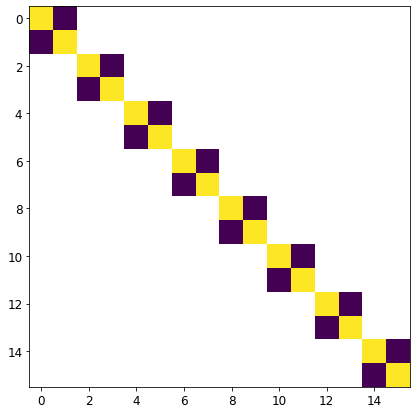

In [61]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [64]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = 3 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:3, npar_adj:16, nnz_obs:33


In [65]:
# calculate
n = 12 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

In [19]:
pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

noptmax:-1, npar_adj:80, nnz_obs:33


In [20]:
t_d ="master_glm"
case="pest_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
kp0_inst:0,kp0_inst:0,log,10,0,1,-1,0.5
kp0_inst:1,kp0_inst:1,log,10,0,1,-1,0.5
kp1_inst:0,kp1_inst:0,log,10,0,1,-1,0.5
kp1_inst:1,kp1_inst:1,log,10,0,1,-1,0.5
kp2_inst:0,kp2_inst:0,log,10,0,1,-1,0.5
kp2_inst:1,kp2_inst:1,log,10,0,1,-1,0.5
kp3_inst:0,kp3_inst:0,log,10,0,1,-1,0.5
kp3_inst:1,kp3_inst:1,log,10,0,1,-1,0.5


In [21]:
pst.control_data.noptmax = 20
pst.control_data.pestmode = "regularization"

pst.pestpp_options["n_iter_base"] = 1 
pst.pestpp_options["n_iter_super"] = 4 
pst.pestpp_options["glm_num_reals"] = 50 
#
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case) 
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case) 
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.helpers.zero_order_tikhonov(pst)

noptmax:20, npar_adj:80, nnz_obs:33


In [22]:
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../pestpp-glm","{}.pst".format(case),num_workers=n,worker_root=".",
                           master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

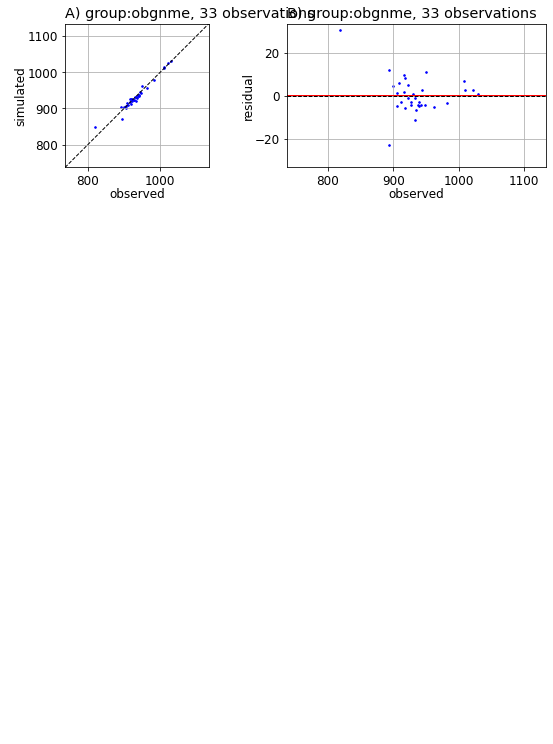

In [23]:
pst_a = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_a.plot(kind='1to1')

C:\ProgramData\Anaconda3\lib\site-packages\pyemu\en.py:384: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn(


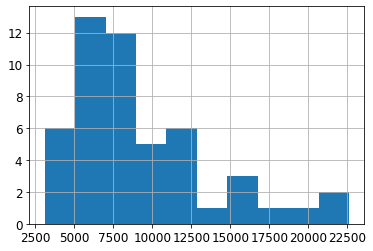

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
ax = oe.phi_vector.hist()

In [25]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
10**dfp["post_mean"]

name
KP0_INST:0_I:30_J:90      0.100000
KP0_INST:0_I:30_J:150     0.100000
KP0_INST:0_I:90_J:90      0.100000
KP0_INST:0_I:90_J:150     0.100000
KP0_INST:0_I:150_J:30     0.100000
                            ...   
KP3_INST:1_I:150_J:90     0.240764
KP3_INST:1_I:150_J:150    0.352132
KP3_INST:1_I:210_J:30     0.147861
KP3_INST:1_I:210_J:90     0.350665
KP3_INST:1_I:210_J:150    0.191321
Name: post_mean, Length: 80, dtype: float64

(array([20.,  6., 20., 12.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  1., 11.]),
 array([ 0.1 ,  0.43,  0.76,  1.09,  1.42,  1.75,  2.08,  2.41,  2.74,
         3.07,  3.4 ,  3.73,  4.06,  4.39,  4.72,  5.05,  5.38,  5.71,
         6.04,  6.37,  6.7 ,  7.03,  7.36,  7.69,  8.02,  8.35,  8.68,
         9.01,  9.34,  9.67, 10.  ]),
 <BarContainer object of 30 artists>)

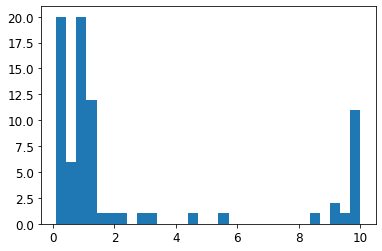

In [26]:
plt.hist(10**dfp["post_mean"],bins=30)

In [27]:
pst.parameter_data.parval1 = 10**dfp["post_mean"].values
pst.control_data.noptmax = 0 # one run with optimal parameters

pst.write(os.path.join(t_d,"{}.pst".format(case)))

pyemu.os_utils.run("..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:80, nnz_obs:33


Text(0.5, 1.0, 'k after inversion')

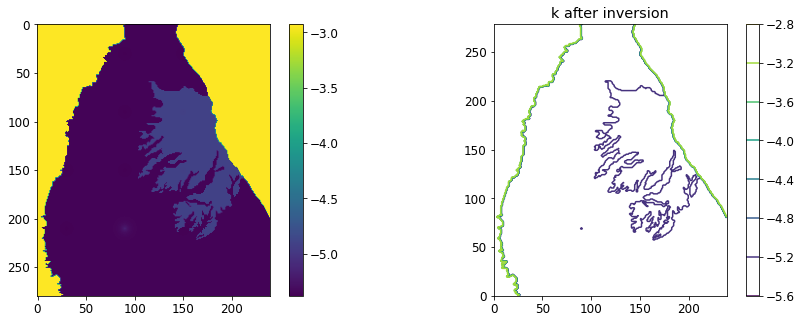

In [28]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join(t_d,"hk0.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join(t_d,"hk0.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

Text(0.5, 1.0, 'k after inversion')

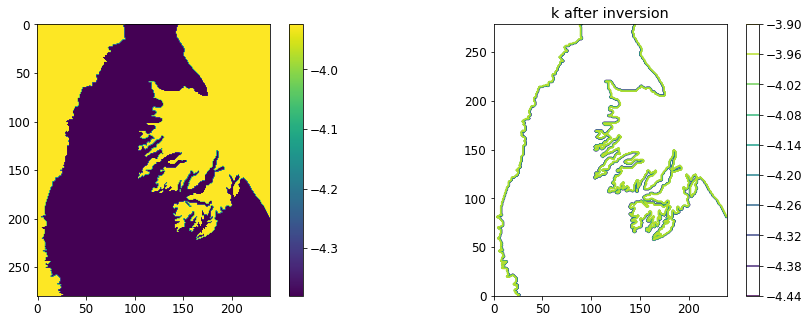

In [29]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join("workspace","hk0.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join("workspace","hk0.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

2455.4976000000006 {'obgnme': 2455.4976000000006} {'obgnme': 1.0}


[None,
 None,
 <AxesSubplot:>,
 <AxesSubplot:xlabel='model runs', ylabel='$\\phi$'>]

<Figure size 576x756 with 0 Axes>

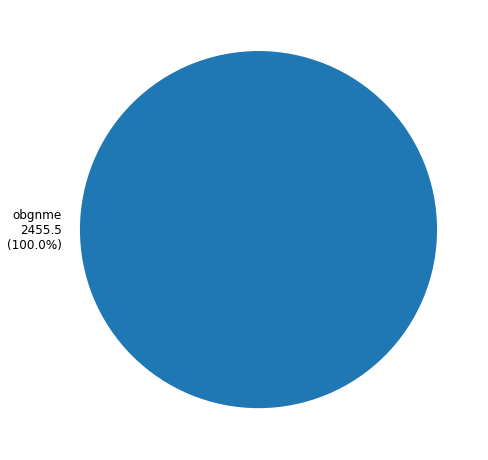

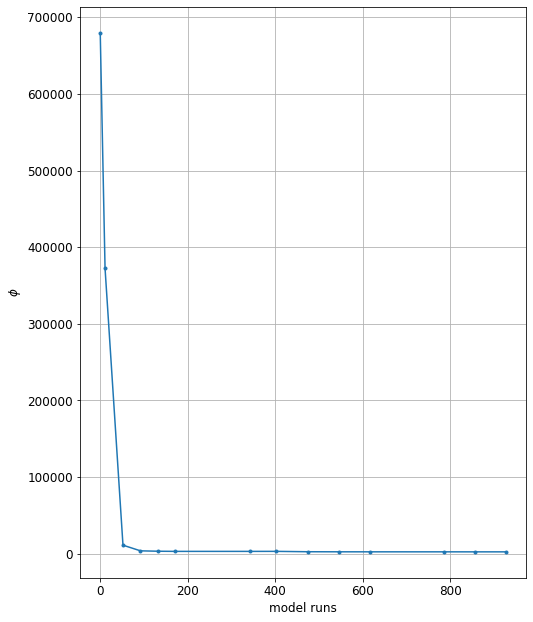

In [30]:
pst_a.plot()